In [1]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import sys
import nmmn.plots
import seaborn as sns
import os
import time
from scipy import interpolate
sys.path.append('../Code')
import PSTHM 
parula=nmmn.plots.parulacmap() # for MATLAB's cmap

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")


### Replicating Piecuch's MCMC method for incorporating limiting data

This post is based on:

https://github.com/christopherpiecuch/bayesGavle/blob/main/model4.m#L282

**1. Data Loading**

In [2]:
import scipy.io as sio
y = sio.loadmat('20230628_data4.mat')['z'][:,0]
x = np.array(sio.loadmat('20230628_data4.mat')['s'],dtype=float)[:,0]
y_sigma = sio.loadmat('20230628_data4.mat')['zet'][:,0]
x_sigma = sio.loadmat('20230628_data4.mat')['sig'][:,0]
ind = sio.loadmat('20230628_data4.mat')['ind'][:,0]

sort_index = np.argsort(x)
y = y[sort_index]
x = x[sort_index]
y_sigma = y_sigma[sort_index]
x_sigma = x_sigma[sort_index]
ind = ind[sort_index]

SLIP_index = ind==0
TL_index = ind==1
ML_index = ind==-1


SLIP_X = x[SLIP_index]
SLIP_y = y[SLIP_index]
SLIP_x_sigma = x_sigma[SLIP_index]
SLIP_y_sigma = y_sigma[SLIP_index]

TL_X = x[TL_index]
TL_y = y[TL_index]
TL_x_sigma = x_sigma[TL_index]
TL_y_sigma = y_sigma[TL_index]

ML_X = x[ML_index]
ML_y = y[ML_index]
ML_x_sigma = x_sigma[ML_index]
ML_y_sigma = y_sigma[ML_index]



In [31]:
rsl_data = np.loadtxt('Maine_RSL/MaineBarilsiteall.dat')
site_index = rsl_data[:,9]==1
rsl_data = rsl_data[site_index]
x = rsl_data[:,2]*1000
y = rsl_data[:,5]
x_sigma = (rsl_data[:,3]+rsl_data[:,4])/4*1000
y_sigma = (rsl_data[:,6]+rsl_data[:,7])/4
ind = rsl_data[:,8]

sort_index= np.argsort(x)
x = x[sort_index]
y = y[sort_index]
x_sigma = x_sigma[sort_index]
y_sigma = y_sigma[sort_index]
ind = ind[sort_index]

SLIP_index = ind==0
TL_index = ind==1
ML_index = ind==-1

SLIP_X = x[SLIP_index]
SLIP_y = y[SLIP_index]
SLIP_x_sigma = x_sigma[SLIP_index]
SLIP_y_sigma = y_sigma[SLIP_index]

TL_X = x[TL_index]
TL_y = y[TL_index]
TL_x_sigma = x_sigma[TL_index]
TL_y_sigma = y_sigma[TL_index]

ML_X = x[ML_index]
ML_y = y[ML_index]
ML_x_sigma = x_sigma[ML_index]
ML_y_sigma = y_sigma[ML_index]

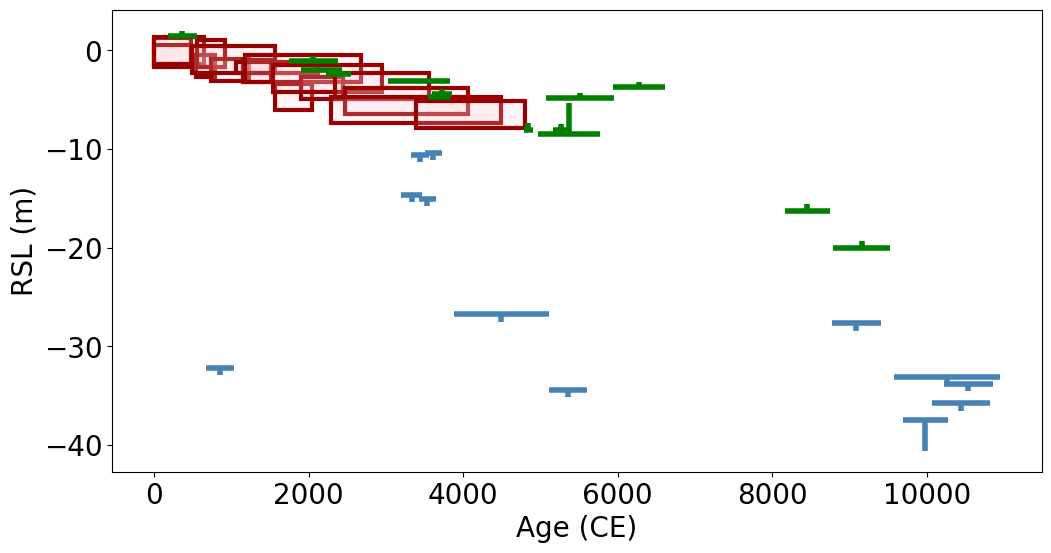

In [3]:
PSTHM.plot_uncertainty_boxes(SLIP_X,SLIP_y,SLIP_x_sigma*2,SLIP_y_sigma*2)
plt.errorbar(TL_X,TL_y,xerr=TL_x_sigma,yerr=[[0]*len(TL_X),2*TL_y_sigma],fmt='None',color='green',label='TL',linewidth=4)
plt.errorbar(ML_X,ML_y,xerr=ML_x_sigma,yerr=[2*ML_y_sigma,[0]*len(ML_X)],fmt='None',color='steelblue',label='ML',linewidth=4);

**2. Maximum Likelihood Estimate As Initial Guess**

  0%|          | 0/300 [00:00<?, ?it/s]

Execution time: 1.774 s


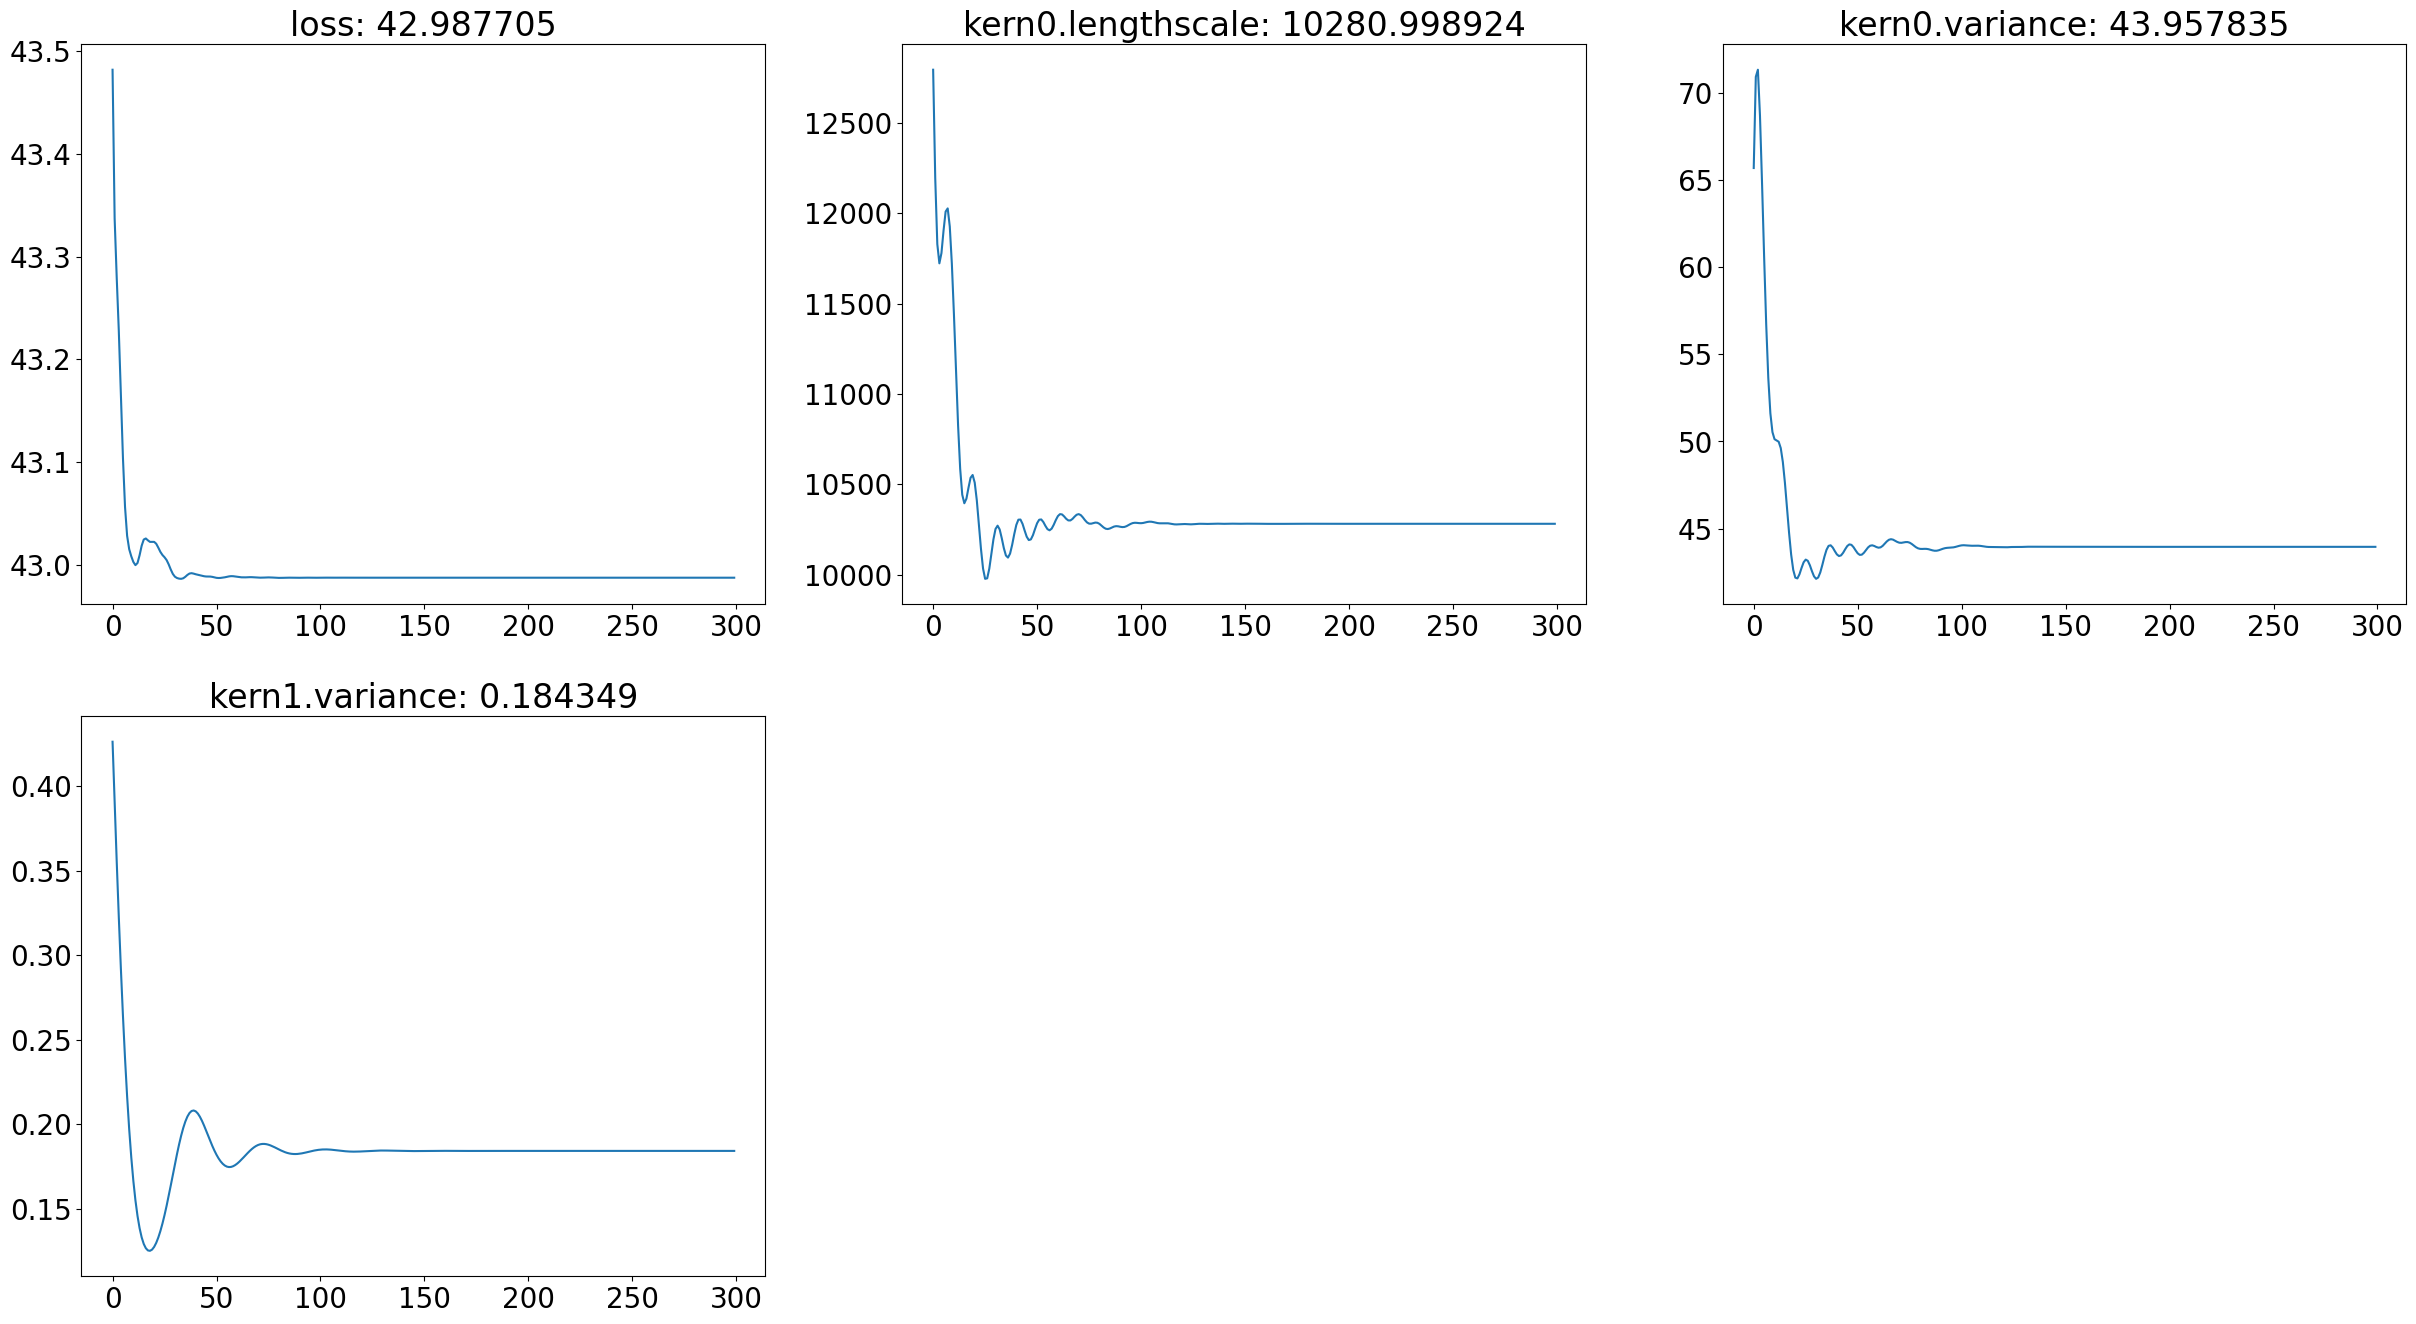

In [4]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate kernels 
Matern32_kernel = gp.kernels.Matern32(input_dim=1)
Matern32_kernel.set_prior("variance", dist.Uniform(torch.tensor(10.), torch.tensor(500.)))
Matern32_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1000.), torch.tensor(20000.)))

# Matern32_kernel2 = gp.kernels.Matern32(
#     input_dim=1)
# Matern32_kernel2.set_prior("variance", dist.Uniform(torch.tensor(0.001), torch.tensor(50.)))
# Matern32_kernel2.set_prior("lengthscale", dist.Uniform(torch.tensor(10.), torch.tensor(50.)))

Whitenoise_kernel = gp.kernels.WhiteNoise(
    input_dim=1, variance=torch.tensor(1))
Whitenoise_kernel.set_prior('variance', dist.Uniform(torch.tensor(1e-3**2), torch.tensor(1.)))

# combined_kernel = gp.kernels.Sum(Matern32_kernel, Matern32_kernel2)
combined_kernel = gp.kernels.Sum(Matern32_kernel, Whitenoise_kernel)

gpr = PSTHM.GPRegression_V(torch.tensor(SLIP_X), torch.tensor(SLIP_y), combined_kernel,noise=torch.tensor(SLIP_y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.SVI_NI_optm(gpr,torch.tensor(SLIP_x_sigma),num_iteration=300,lr=0.15)

PSTHM.plot_track_list(track_list)
et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

# torch.save(gpr, 'testing')

# gpr = torch.load('testing')



**3. Modify GP Prediction to Fit Limiting Data**

In details, we set make limiting data that GP does not fit as pseduo sea-level index point. 

In [5]:
test_ind = ind.copy()
while True:
    test_pred,test_cov = gpr(torch.tensor(x))
    test_pred = test_pred.detach().numpy()
    test_std = test_cov.sqrt().detach().numpy()
    index = ((test_pred >y) & (test_ind==1))  | ((test_pred <y) & (test_ind==-1))
    test_ind[index] = 0
    if np.sum(index) == 0:
        break
    gpr.X = torch.tensor(x[test_ind==0])    
    gpr.y = torch.tensor(y[test_ind==0])
    gpr.noise = torch.tensor(y_sigma[test_ind==0]**2)

vio_TL_index = (test_pred >y) & (TL_index==1)
vio_ML_index = (test_pred <y) & (ML_index==1)
test_pred[vio_TL_index] = y[vio_TL_index] - 2*y_sigma[vio_TL_index]
test_pred[vio_ML_index] = y[vio_ML_index] + 2*y_sigma[vio_ML_index]

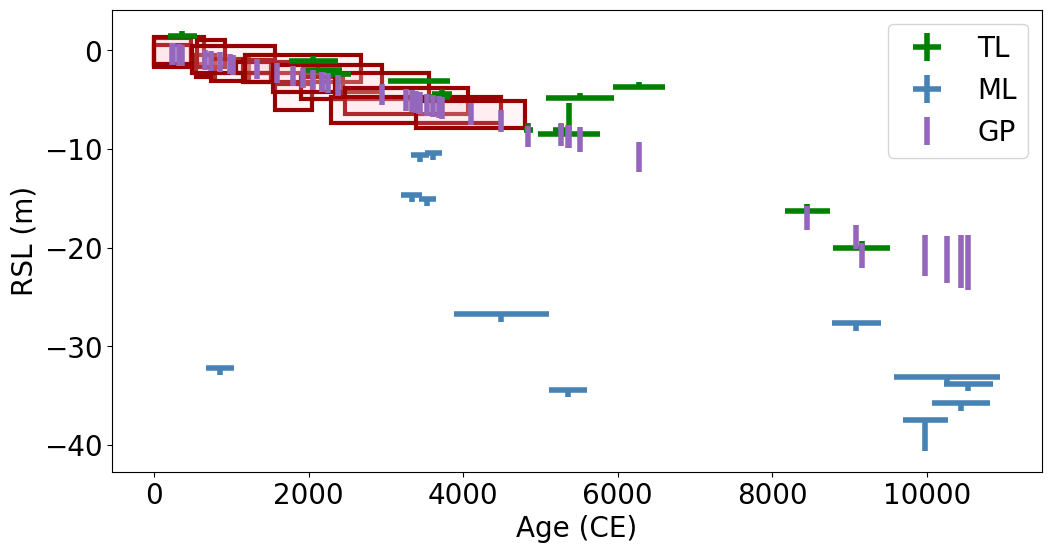

In [6]:
PSTHM.plot_uncertainty_boxes(SLIP_X,SLIP_y,SLIP_x_sigma*2,SLIP_y_sigma*2)

plt.errorbar(TL_X,TL_y,xerr=TL_x_sigma,yerr=[[0]*len(TL_X),2*TL_y_sigma],fmt='None',color='green',label='TL',linewidth=4)
plt.errorbar(ML_X,ML_y,xerr=ML_x_sigma,yerr=[2*ML_y_sigma,[0]*len(ML_X)],fmt='None',color='steelblue',label='ML',linewidth=4)
plt.errorbar(x,test_pred,yerr = test_cov.sqrt().detach().numpy()*2,fmt='None',color='C4',label='GP',linewidth=4)
plt.legend()

In [7]:
def cal_limiting_log_likelihood(prop_y,y,y_sigma,limiting_type):
    '''A function to calulate log likelihood for limiting data that combines each datum's 
    normally-distributed measurement uncertainty and stepwise indicative meaning 
    
    
    ----------Inputs-----------
    prop_y: the proposed new y value
    y: observed elevation value
    y_sigma: the measurement uncertainty of y
    limiting_type: the type of limiting data, 1 for terrestrial limiting, -1 for marine limiting
    '''

    limiting_log_likelihood = 0
    if limiting_type == 1:
        fit_index = prop_y < y
        limiting_log_likelihood +=np.log(np.e)*(fit_index.sum())
        if fit_index.sum()<len(y):
            #multiply by 2 because the elevation uncertainty is assumed to be truncated normal distribution,
            # which is truncated from to 0 to inf
            limiting_log_likelihood += np.log(stats.norm(y[~fit_index],y_sigma[~fit_index]).pdf(prop_y[~fit_index])*2).sum()
    elif limiting_type == -1:
        fit_index = prop_y > y
        limiting_log_likelihood +=np.log(np.e)*(fit_index.sum())

        if fit_index.sum()<len(y):
            #multiply by 2 because the elevation uncertainty is assumed to be truncated normal distribution,
            # which is truncated from to -inf to 0
            limiting_log_likelihood += np.log(stats.norm(y[~fit_index],y_sigma[~fit_index]).pdf(prop_y[~fit_index])*2).sum()
    return limiting_log_likelihood


def cal_limiting_log_likelihood2(prop_y,y,limiting_type):
    '''A function to calulate log likelihood for limiting data that combines each datum's 
    normally-distributed measurement uncertainty and stepwise indicative meaning 
    
    ----------Inputs-----------
    prop_y: the proposed new y value
    y: observed elevation value
    limiting_type: the type of limiting data, 1 for terrestrial limiting, -1 for marine limiting
    '''

    limiting_log_likelihood = 0
    if limiting_type == 1:
        limiting_log_likelihood += np.log((prop_y < y)+1e-10).sum() 

    elif limiting_type == -1:
        fit_index = prop_y > y
        limiting_log_likelihood +np.log((prop_y > y)+1e-10).sum() 

    return limiting_log_likelihood

In [8]:
import scipy.stats as stats
from tqdm.notebook import tqdm

np.random.seed(1358)
#-----------create store for posterior samples----------------
sample_size = 20000
burn_in =1000
total_size = sample_size+burn_in
post_x = np.zeros((sample_size,len(x)))
post_y = np.zeros((sample_size,len(x)))
post_length = np.zeros((sample_size,1))
post_variance = np.zeros((sample_size,1))
post_noise = np.zeros((sample_size,1))
post_log_likelihood = np.zeros((sample_size,1))
post_limiting = np.zeros((sample_size,len(x)))

#-----------Set initial values----------------
y_store = test_pred.copy()
x_store = x.copy()
x_store = x_store + np.random.normal(0,x_sigma)
random_y = y.copy()  #this variance is used to sample random elevation uncertainty of limiting data
length_store = track_list['kern0.lengthscale'].iloc[-1]
variance_store = track_list['kern0.variance'].iloc[-1]
noise_store = track_list['kern1.variance'].iloc[-1]
gpr.noise = torch.tensor(y_sigma**2)*0
gpr.X = torch.tensor(x_store)
gpr.y = torch.tensor(y_store)
prob_now = -10000
#-----------Start MCMC----------------
for nn in tqdm(range(sample_size+burn_in)):

    all_cov = gpr.kernel(torch.tensor(x_store)).detach().numpy()
    gpr.X = torch.tensor(x_store)
    gpr.y = torch.tensor(y_store)
    for i in range(len(x)):
        
        test_cov = np.delete(all_cov,i,axis=0)
        test_cov = np.delete(test_cov,i,axis=1)
        test_cov_single = np.delete(all_cov[i:i+1],i)
        Kt_K = test_cov_single @  np.linalg.inv(test_cov)
        GP_y = Kt_K @ np.delete(y_store,i)
        GP_var = all_cov[i,i] - Kt_K @ test_cov_single.T
        
        if ind[i] ==0:
            prop_y = np.average([GP_y,random_y[i]],weights=[1/GP_var,1/y_sigma[i]**2])
            prop_var = np.average([GP_var,y_sigma[i]**2],weights=[1/GP_var,1/y_sigma[i]**2])
        else:
            prop_y,prop_var = GP_y,GP_var

        #-------update y --------------------
        prop_std = np.sqrt(prop_var+1e-4) #add a small number to avoid nan
        test_y =  np.random.normal(prop_y,prop_std)
        
        if ind[i] ==0:
            y_store[i] = test_y
        
        elif ind[i]==1:
            if test_y < random_y[i]:
                y_store[i] = test_y
                random_y[i] = np.random.normal(y[i],y_sigma[i])

        elif ind[i]==-1:
            if test_y > random_y[i]:
                y_store[i] = test_y
                random_y[i] = np.random.normal(y[i],y_sigma[i])
    # get the execution time
    
    #-------update age --------------------

    prop_x = np.random.normal(x,x_sigma)
    x_store = prop_x

    #-------update hyperparameters after burn-in iteration------
    
    

    random_TL_y = random_y[TL_index]
    random_ML_y = random_y[ML_index]
    
    #-------update length scale--------------------------------
    prop_y,_ = gpr(torch.tensor(x_store))
    prop_y = prop_y.detach().numpy()


    #-------update length scale--------------------------------
    prop_length = np.random.normal(length_store,250)
    if prop_length<2000: prop_length=2000.
    elif prop_length>20000: prop_length=20000.
    gpr.kernel.kern0.lengthscale = torch.tensor(prop_length)
    prop_y,_ = gpr(torch.tensor(x_store))
    prop_y = prop_y.detach().numpy()
    SLIP_log_likelihood = np.log(stats.norm(SLIP_y,SLIP_y_sigma).pdf(prop_y[SLIP_index]))
    SLIP_log_likelihood[SLIP_log_likelihood<-50]=-50 #avoid nan
    SLIP_log_likelihood = SLIP_log_likelihood.sum()
    TL_log_likelihood = cal_limiting_log_likelihood2(prop_y[TL_index],random_TL_y,1)
    ML_log_likelihood = cal_limiting_log_likelihood2(prop_y[ML_index],random_ML_y,-1)    
    prop_log_likelihood = SLIP_log_likelihood + TL_log_likelihood + ML_log_likelihood
    prob_now = prop_log_likelihood

    
    SLIP_log_likelihood = np.log(stats.norm(SLIP_y,SLIP_y_sigma).pdf(prop_y[SLIP_index]))
    SLIP_log_likelihood[SLIP_log_likelihood<-50]=-50 #avoid nan
    SLIP_log_likelihood = SLIP_log_likelihood.sum()
    TL_log_likelihood = cal_limiting_log_likelihood2(prop_y[TL_index],random_TL_y,1)
    ML_log_likelihood = cal_limiting_log_likelihood2(prop_y[ML_index],random_ML_y,-1)    
    prop_log_likelihood = SLIP_log_likelihood + TL_log_likelihood + ML_log_likelihood
    
    y_prob = np.exp(prop_log_likelihood - prob_now)
    y_acc_prob = np.min([1,y_prob])
    
    if np.random.rand() < y_acc_prob:
        prob_now = prop_log_likelihood
        length_store = prop_length
    else:
        gpr.kernel.kern0.lengthscale = torch.tensor(length_store)

    #-------update variance--------------------------------
    prop_variance = np.random.normal(variance_store,5)
    if prop_variance<10: prop_variance = 10.
    elif prop_variance>100: prop_variance =100.
    gpr.kernel.kern0.variance = torch.tensor(prop_variance)
    prop_y,_ = gpr(torch.tensor(x_store))
    prop_y = prop_y.detach().numpy()

    SLIP_log_likelihood = np.log(stats.norm(SLIP_y,SLIP_y_sigma).pdf(prop_y[SLIP_index]))
    SLIP_log_likelihood[SLIP_log_likelihood<-50]=-50 #avoid nan
    SLIP_log_likelihood = SLIP_log_likelihood.sum()
    TL_log_likelihood = cal_limiting_log_likelihood2(prop_y[TL_index],random_TL_y,1)
    ML_log_likelihood = cal_limiting_log_likelihood2(prop_y[ML_index],random_ML_y,-1)    
    prop_log_likelihood = SLIP_log_likelihood + TL_log_likelihood + ML_log_likelihood
    
    y_prob = np.exp(prop_log_likelihood - prob_now)
    y_acc_prob = np.min([1,y_prob])

    if np.random.rand() < y_acc_prob:
        prob_now = prop_log_likelihood
        variance_store = prop_variance
    else:
        gpr.kernel.kern0.variance = torch.tensor(variance_store)

    #-------update noise--------------------------------
    prop_noise = np.random.normal(noise_store,0.05)
    if prop_noise>1: prop_noise = 1.
    elif prop_noise<1e-4: prop_noise = 1e-4
    gpr.kernel.kern1.variance = torch.tensor(prop_noise)
    prop_y,_ = gpr(torch.tensor(x_store))
    prop_y = prop_y.detach().numpy()

    SLIP_log_likelihood = np.log(stats.norm(SLIP_y,SLIP_y_sigma).pdf(prop_y[SLIP_index]))
    SLIP_log_likelihood[SLIP_log_likelihood<-11]=-11 #avoid nan
    SLIP_log_likelihood = SLIP_log_likelihood.sum()
    TL_log_likelihood = cal_limiting_log_likelihood2(prop_y[TL_index],random_TL_y,1)
    ML_log_likelihood = cal_limiting_log_likelihood2(prop_y[ML_index],random_ML_y,-1)    
    prop_log_likelihood = SLIP_log_likelihood + TL_log_likelihood + ML_log_likelihood
    y_prob = np.exp(prop_log_likelihood - prob_now)
    y_acc_prob = np.min([1,y_prob])
    if np.isnan(y_acc_prob): 
        print('Got a problem with likelihood calculation!')
        break 
    if np.random.rand() < y_acc_prob:
        prob_now = prop_log_likelihood
        noise_store = prop_noise
    else:
        gpr.kernel.kern1.variance = torch.tensor(noise_store)
        
    #---------Store posterior ---------------
    if nn< burn_in: continue
    post_x[nn-burn_in] = x_store
    post_y[nn-burn_in] = y_store
    post_length[nn-burn_in] = length_store
    post_variance[nn-burn_in] = variance_store
    post_noise[nn-burn_in] = noise_store
    post_log_likelihood[nn-burn_in] = prob_now
    post_limiting[nn-burn_in] = random_y
    if np.isnan(post_y).sum()>0: 
        print('Got a nan value in your posterior values!')
        break
    

#--------Thinning posterior -------------
#filter out lier
post_x = post_x[::10]
post_y = post_y[::10]
post_length = post_length[::10]
post_variance = post_variance[::10]
post_noise = post_noise[::10]
post_log_likelihood = post_log_likelihood[::10]

  0%|          | 0/21000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'log likelihood')

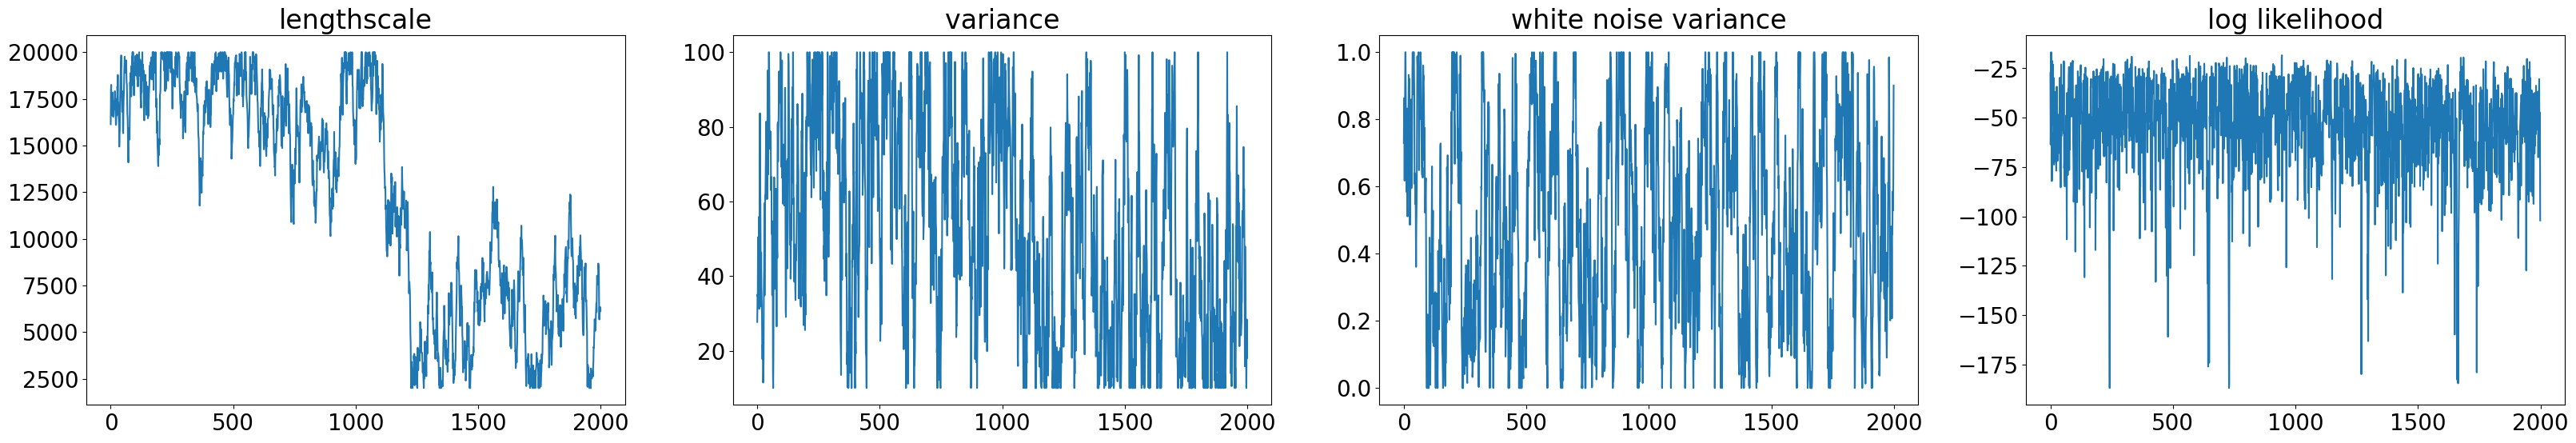

In [13]:
plt.figure(figsize=(40,6))
plt.subplot(141)
plt.plot(np.arange(len(post_length)),post_length)
plt.title('lengthscale')
plt.subplot(142)
plt.plot(np.arange(len(post_length)),post_variance)
plt.title('variance')
plt.subplot(143)
plt.plot(np.arange(len(post_length)),post_noise)
plt.title('white noise variance')
plt.subplot(144)
plt.plot(np.arange(len(post_length)),post_log_likelihood)
plt.title('log likelihood')

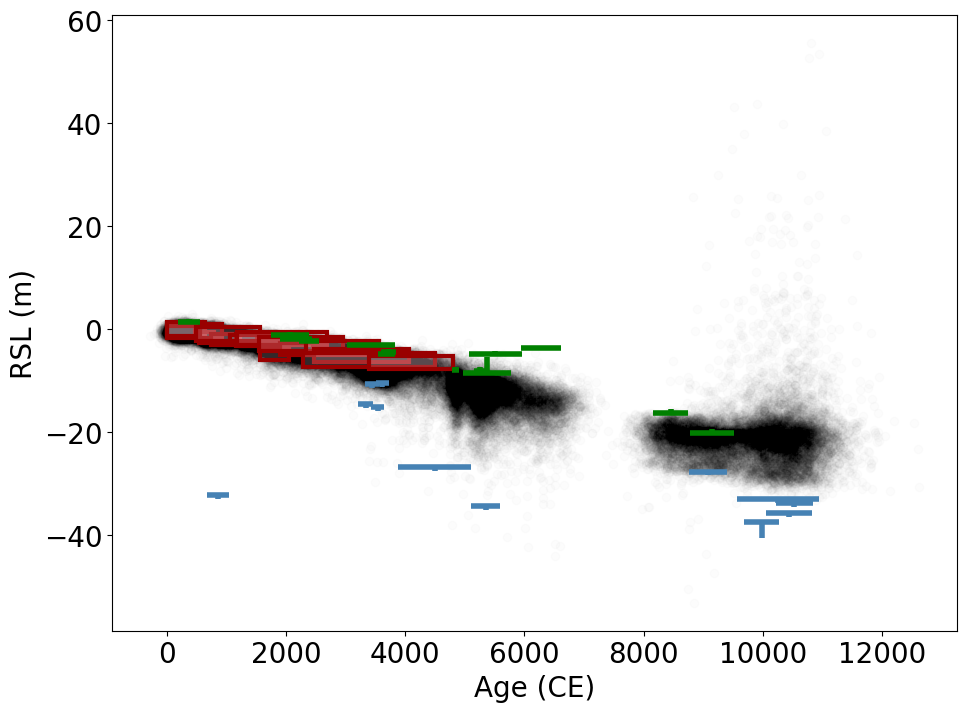

In [14]:
plt.figure(figsize=(24,8))
ax = plt.subplot(121)
PSTHM.plot_uncertainty_boxes(SLIP_X,SLIP_y,SLIP_x_sigma*2,SLIP_y_sigma*2,ax=ax)
plt.errorbar(TL_X,TL_y,xerr=TL_x_sigma,yerr=[[0]*len(TL_X),2*TL_y_sigma],fmt='None',color='green',label='TL',linewidth=4)
plt.errorbar(ML_X,ML_y,xerr=ML_x_sigma,yerr=[2*ML_y_sigma,[0]*len(ML_X)],fmt='None',color='steelblue',label='ML',linewidth=4)

for i in range(len(post_x)):
    plt.scatter(post_x[i],post_y[i],color='k',alpha=0.01)


In [15]:
test_age = torch.arange(0,18100,100).double()
output_y = np.zeros([len(post_y),len(test_age)])
output_rate_y = np.zeros([len(post_y),len(test_age)])
num = 0
gpr.noise = torch.tensor(post_y[0])*0

for i in range(len(post_y)):
    gpr.X = torch.tensor(post_x[i])
    gpr.y = torch.tensor(post_y[i])
    gpr.kernel.kern0.variance = torch.tensor(post_variance[i])
    gpr.kernel.kern0.lenthscale = torch.tensor(post_length[i])
    gpr.kernel.kern1.variance = torch.tensor(post_noise[i])
    test_y,_ = gpr(test_age)
    output_y[num] = test_y.detach().numpy()
    x_test = torch.tensor(test_age.clone(),requires_grad=True)
    test_y,_ = gpr(x_test)
    test_y.sum().backward(retain_graph=True)
    y_rate = x_test.grad
    output_rate_y[num] = y_rate.detach().numpy()
    num+=1


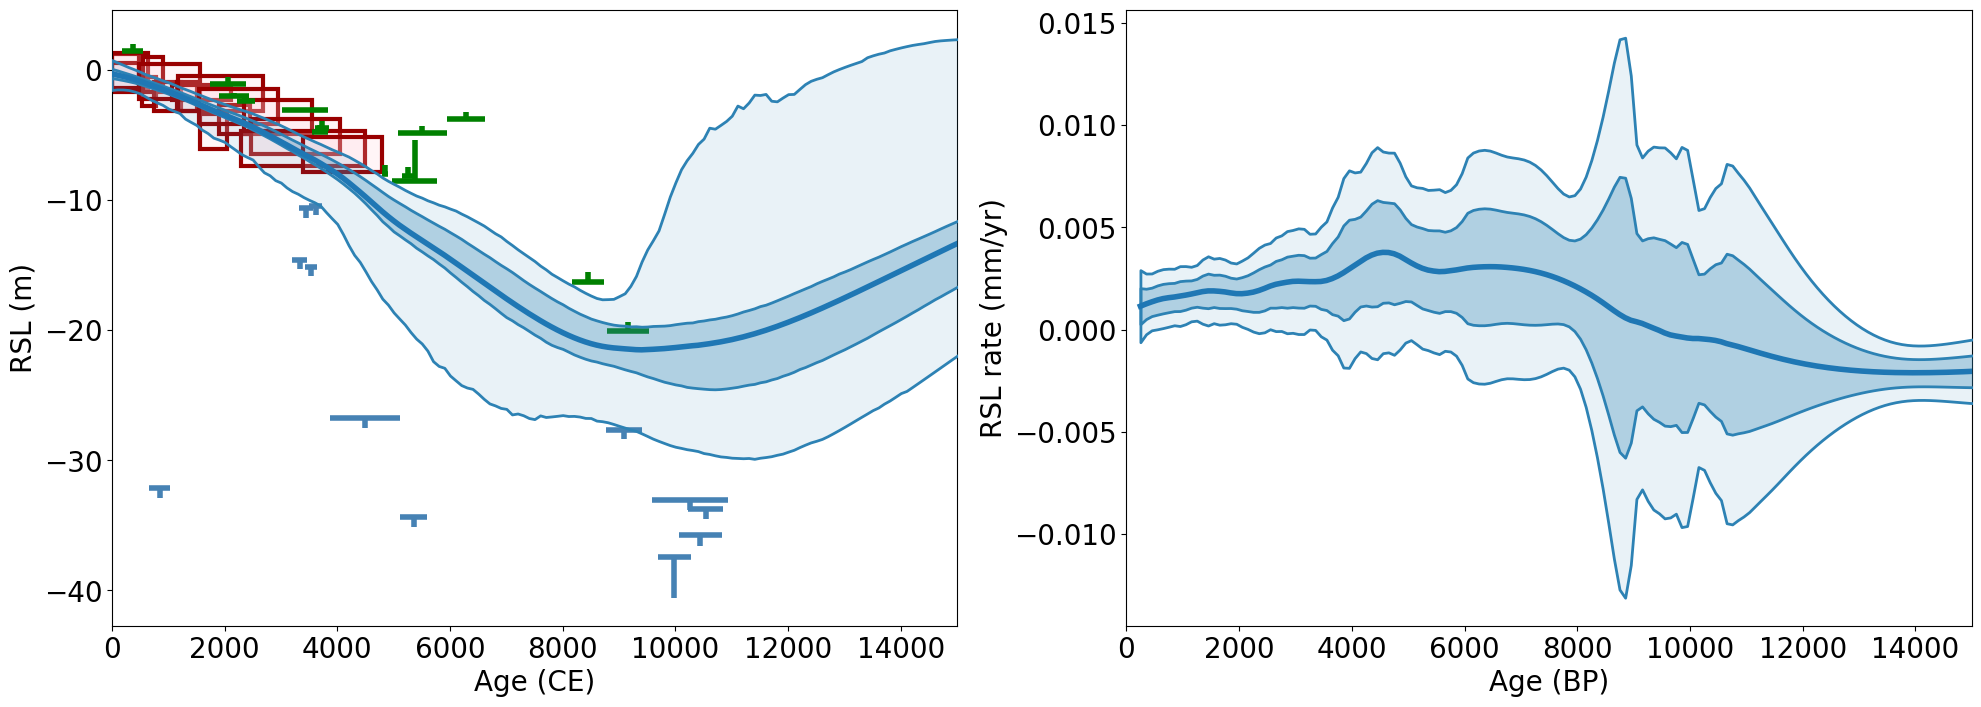

In [24]:
plt.figure(figsize=(24,8))
ax = plt.subplot(121)
PSTHM.plot_uncertainty_boxes(SLIP_X,SLIP_y,SLIP_x_sigma*2,SLIP_y_sigma*2,ax=ax)

plt.errorbar(TL_X,TL_y,xerr=TL_x_sigma,yerr=[[0]*len(TL_X),2*TL_y_sigma],fmt='None',color='green',label='TL',linewidth=4)
plt.errorbar(ML_X,ML_y,xerr=ML_x_sigma,yerr=[2*ML_y_sigma,[0]*len(ML_X)],fmt='None',color='steelblue',label='ML',linewidth=4)

test_mean = np.mean(output_y,axis=0)

test_2p5,test_97p5 = np.percentile(output_y,[2.5,97.5],axis=0)
test_25,test_75 = np.percentile(output_y,[25,75],axis=0)

plt.plot(test_age.detach().numpy(),test_mean,lw=4,zorder=11)
plt.fill_between(test_age.detach().numpy(),test_2p5,test_97p5,facecolor=(0.17450980392156865, 0.5098039215686274, 0.7058823529411765,0.1),
                 edgecolor=(0.17450980392156865, 0.5098039215686274, 0.7058823529411765,1),lw=2,zorder=10)

plt.fill_between(test_age.detach().numpy(),test_25,test_75,facecolor=(0.17450980392156865, 0.5098039215686274, 0.7058823529411765,0.3),
                 edgecolor=(0.17450980392156865, 0.5098039215686274, 0.7058823529411765,1),lw=2,zorder=10)
plt.xlim(0,15000)
plt.subplot(122)
y_var = np.cov(output_y.T)
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(test_age.detach().numpy(),y_var,test_mean,difftimestep=500)

plt.plot(rsl_time,-rsl_rate,lw=4,zorder=11)

plt.fill_between(rsl_time,-rsl_rate-2*rsl_rate_sd,-rsl_rate+2*rsl_rate_sd,facecolor=(0.17450980392156865, 0.5098039215686274, 0.7058823529411765,0.1),
                 edgecolor=(0.17450980392156865, 0.5098039215686274, 0.7058823529411765,1),lw=2,zorder=10)
plt.fill_between(rsl_time,-rsl_rate-rsl_rate_sd,-rsl_rate+rsl_rate_sd,facecolor=(0.17450980392156865, 0.5098039215686274, 0.7058823529411765,0.3),
                 edgecolor=(0.17450980392156865, 0.5098039215686274, 0.7058823529411765,1),lw=2,zorder=10)
plt.xlabel('Age (BP)')
plt.ylabel('RSL rate (mm/yr)')
plt.xlim(0,15000);

In [ ]:
# def weighted_percentile(data, percents, weights=None):
#     ''' percents in units of 1%
#         weights specifies the frequency (count) of data.
#     '''
#     if weights is None:
#         return np.percentile(data, percents)
#     ind=np.argsort(data)
#     d=data[ind]
#     w=weights[ind]
#     p=1.*w.cumsum()/w.sum()*100
#     y=np.interp(percents, p, d)
#     return y

# #----------weighted mean and quantile----------------
# y_quantile = []
# rate_y_quintile = []
# for i in range(len(test_age)):
#     y_quantile.append(weighted_percentile(output_y[:,i],[2.5,97.5,50],weights = np.exp(post_log_likelihood[:,0])))
#     rate_y_quintile.append(weighted_percentile(output_rate_y[:,i],[2.5,97.5,50],weights = np.exp(post_log_likelihood[:,0])))
# y_quantile = np.array(y_quantile)
# rate_y_quintile = np.array(rate_y_quintile)
# y_mean = np.average(output_y,axis=0,weights = np.exp(post_log_likelihood[:,0]))
# rate_y_mean = np.average(output_rate_y,axis=0,weights = np.exp(post_log_likelihood[:,0]))